# Hamming distance histograms

Local and global Hamming distance superimposed. 
- Local: the surface of the neutral space 
- Global: the total genotypes in the map

No deleterious ignores the gneotypes of phenotype '.'*L

In [26]:
import pickle 
with open("../data/hammingglobalDPD_nodel.pkl","rb") as f:
    hammingglobalDPD = pickle.load(f)
with open("../data/hamminglocalDPD_nodel.pkl","rb") as f:
    hamminglocalDPD = pickle.load(f)
with open("../data/edgeD.pkl","rb") as f:
    edgeD = pickle.load(f)
with open("../data/neutralsets.pkl","rb") as f:
    neutralsets = pickle.load(f)
L=12
K=4

In [30]:
from collections import defaultdict
sort_neutralsets = defaultdict(float)
sorted_neutralsets = dict(sorted(neutralsets.items(), key=lambda item: item[1], reverse=True))
for k, v in sorted_neutralsets.items():
    k = k.replace('\n', '')
    sort_neutralsets[k] = v

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


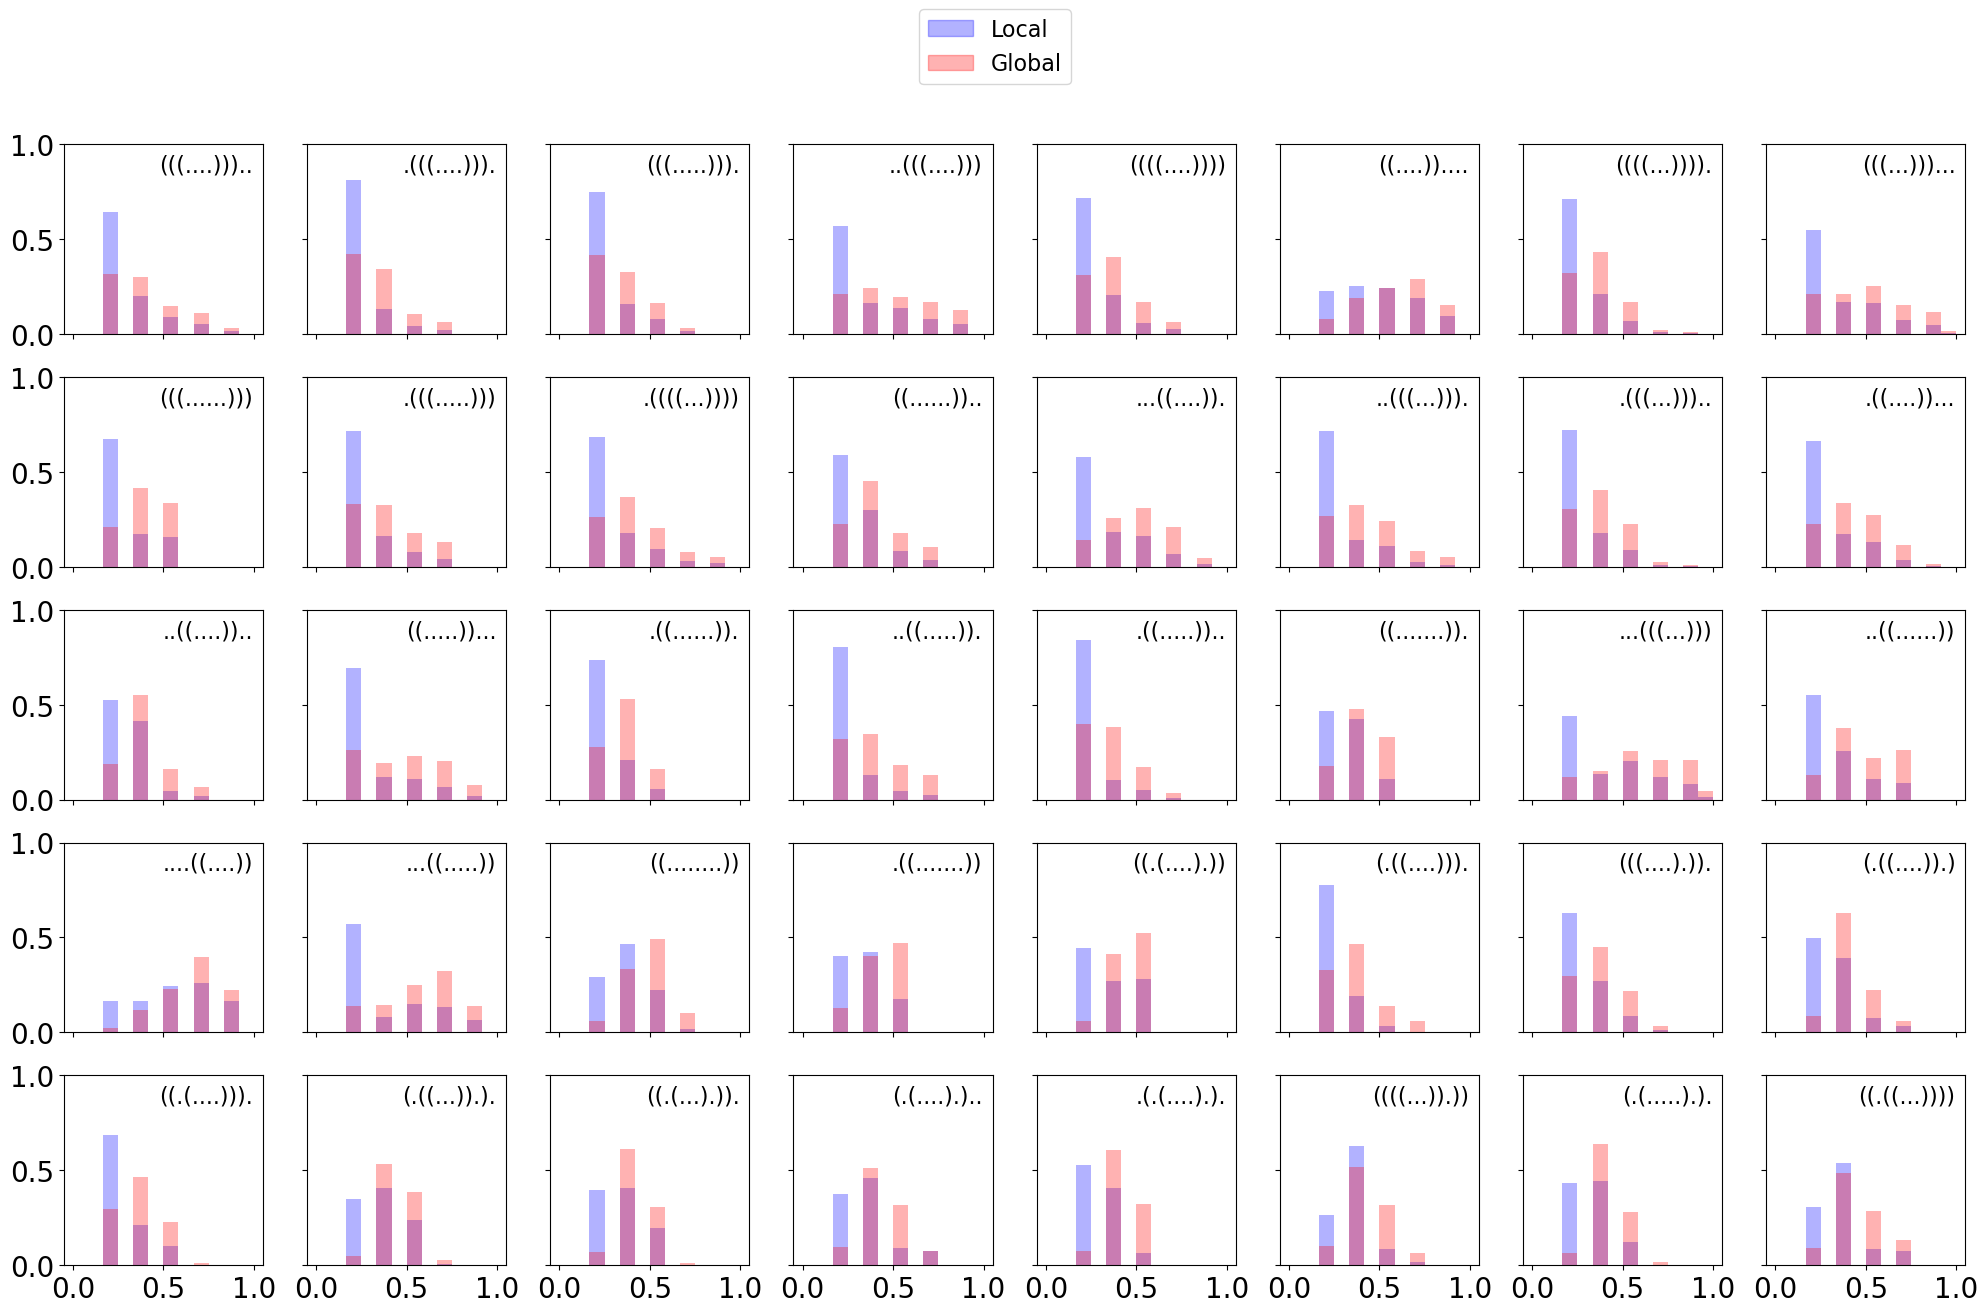

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

fig, axs = plt.subplots(5, 8, figsize=(20, 12), sharex=True, sharey=True)  # 5 rows, 8 columns

bins = np.linspace(0, 1, L+1)


for i, ax in enumerate(axs.flatten()):
    if i < len(hamminglocalDPD):
        key = list(sort_neutralsets.keys())[i+1]

        h_values = list(hamminglocalDPD[key].keys())
        counts = list(hamminglocalDPD[key].values())
        
        ax.hist(h_values, bins=bins, weights=np.array(counts)/(edgeD[key]), color='blue', alpha=0.3)
        
        h_values1 = list(hammingglobalDPD[key].keys())
        counts1 = np.array(list(hammingglobalDPD[key].values()))/np.sum(list(sort_neutralsets.values())[1:])
        
        ax.hist(h_values1, bins=bins, weights=np.array(counts1), color='red', alpha=0.3)
        
        ax.text(0.95, 0.95, key, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=16)
        ax.set_yticks([0.0,0.5,1.0])
        ax.set_xticks([0.0,0.5,1.0])
        ax.tick_params(axis='both', which='major', labelsize=20)  # Set tick label size


blue_patch = mpatches.Patch(color='blue', alpha=0.3, label='Local')
red_patch = mpatches.Patch(color='red', alpha=0.3, label='Global')
fig.legend(handles=[blue_patch, red_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=16)
plt.tight_layout()
plt.savefig("hamming.png", bbox_inches='tight')
plt.show()

# $\phi_{pq}$ with Hamming distance

The $\phi_{pq}$ is the probability of phenotype $q$ mutating to a phenoytpe $p$:

$\sum_p \phi_{pq}$ = 1 

We check that probabilities are higher for similar phenotypes.

Colormap divides warm to cool, with cool colours corresponding to similar phenotypes (low $H$) and  warm colours to less similar (high $H$), normalised from 0-1 with $H-0.5$ as the midpoint for the normalised colormap.

We skip the deleterious and the neutral set.

In [10]:
import pickle
with open("../data/phipq.pkl","rb") as f:
    phipq = pickle.load(f)

L=12
K=4

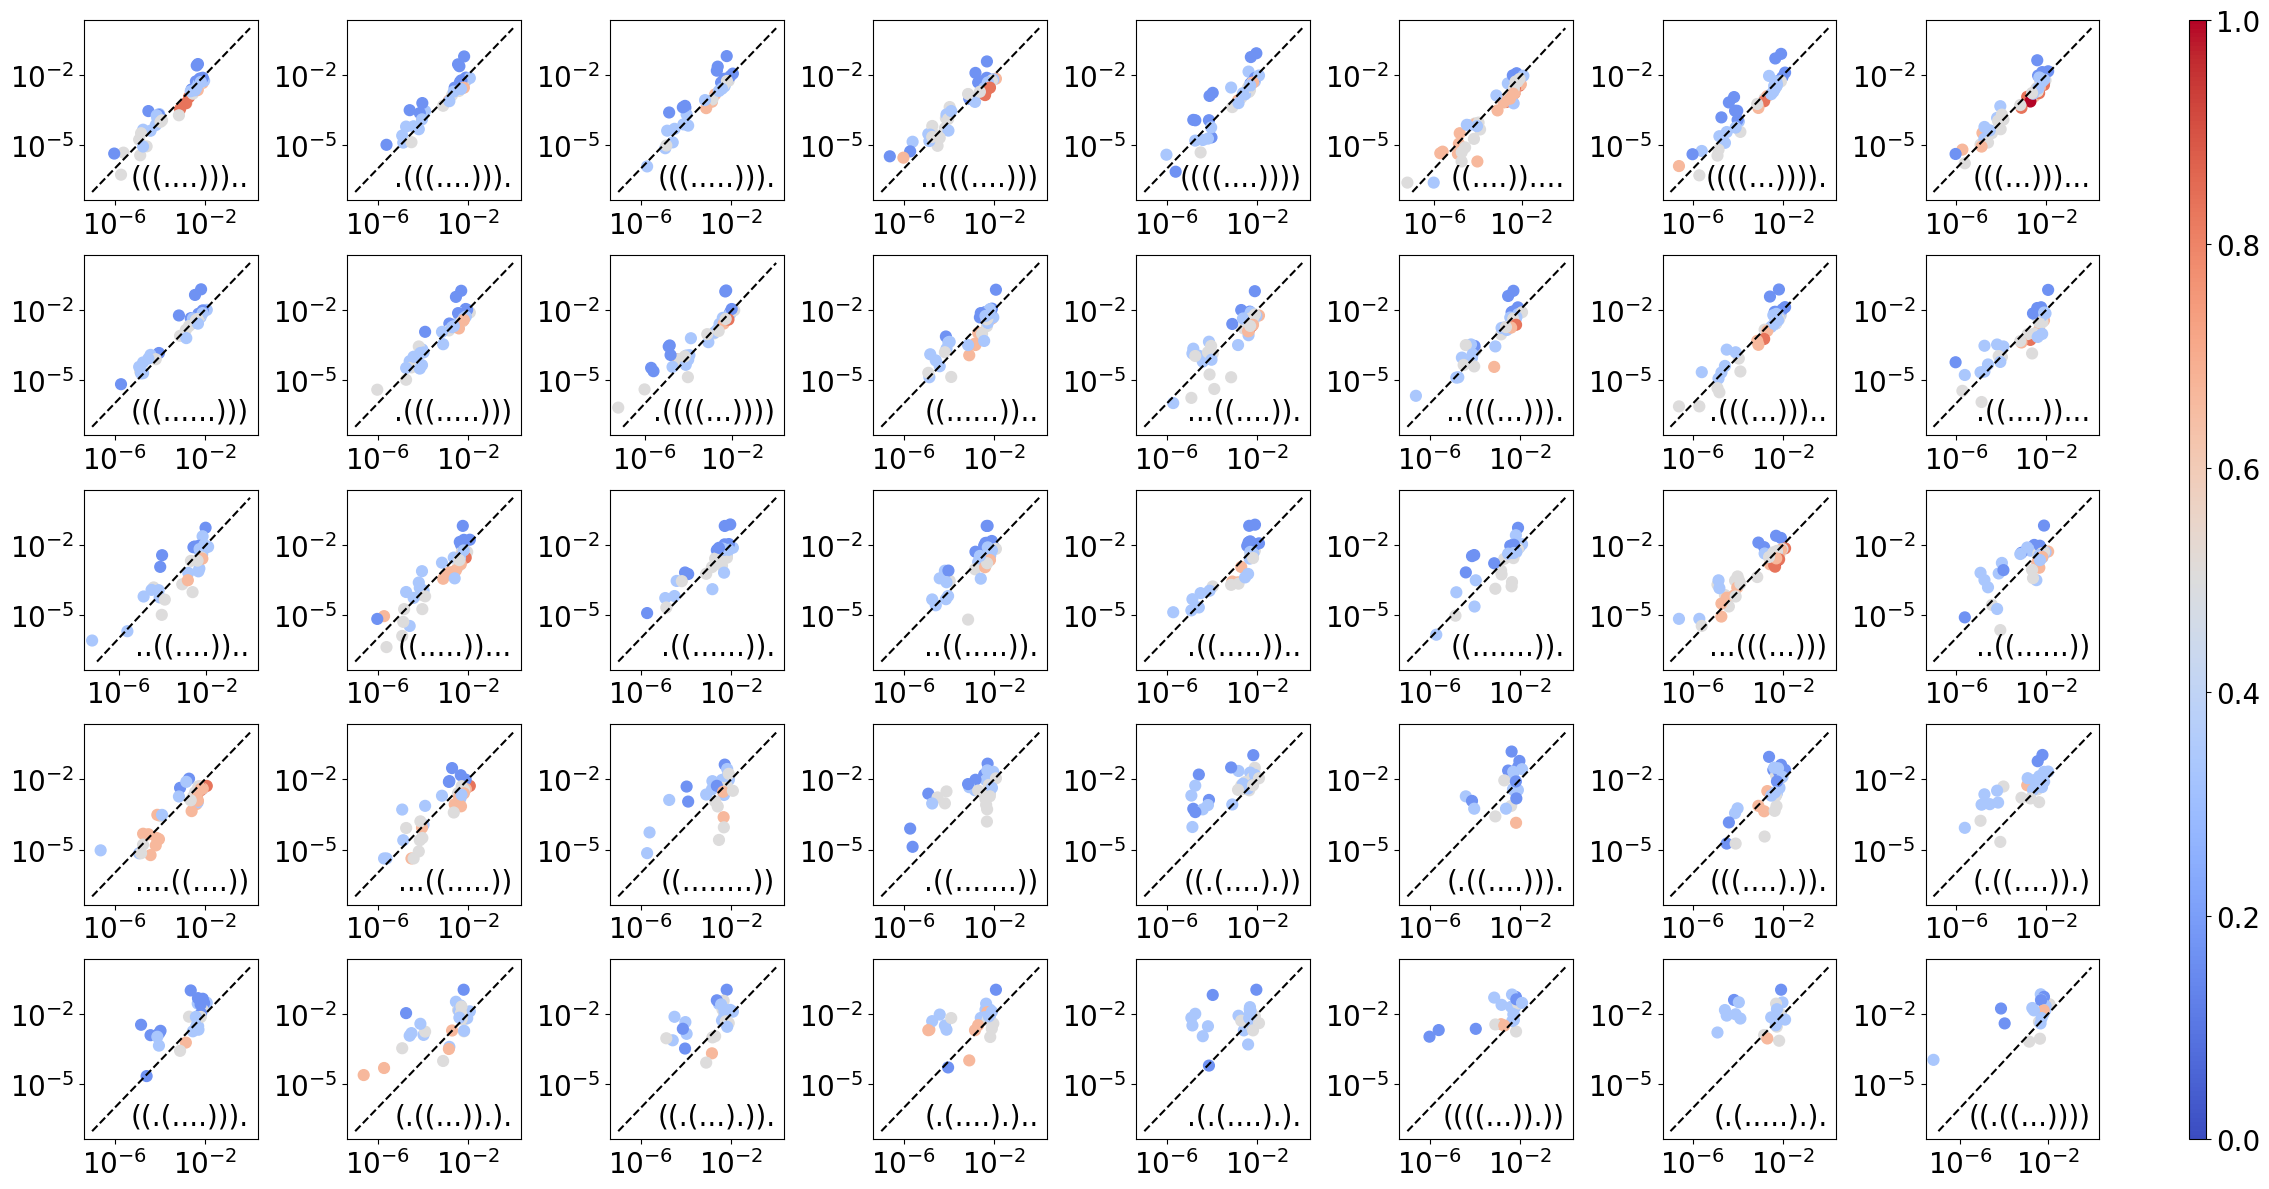

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import sys
from matplotlib.gridspec import GridSpec
sys.path.append('/home/pg520/phenodistance')
from main.functions.structurefunctions import hamming

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0.5, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Normalize the values
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        # Shift the values to the range [0, 1]
        result = np.ma.masked_array((result - vmin) / (vmax - vmin))
        result = np.ma.masked_array(np.interp(result, [0, midpoint, 1], [0, 0.5, 1]))

        if is_scalar:
            result = result[0]
        return result

# Create a grid layout with space for the colorbar
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(5, 9, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.1])

plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
cmap = plt.get_cmap('coolwarm')  # Get the colormap
norm = MidpointNormalize(vmin=0, vmax=1, midpoint=0.5)  # Use custom normalization

axs = [fig.add_subplot(gs[i, j]) for i in range(5) for j in range(8)]

for i, ax in enumerate(axs):
    if i < len(phipq):
        key = list(sort_neutralsets.keys())[i+1]
        qitems = phipq[key]
        listphipq = []
        listhamming = []
        listfreq = []
        
        for q, phi in qitems.items():
            if q == '.'*L or q == key:  # Skip the neutral set and the del sequence
                continue
            listphipq.append(phi)
            listhamming.append(hamming(key, q))
            listfreq.append(neutralsets[q+'\n'] / K**L)
        
        scatter = ax.scatter(listfreq, listphipq, s=60, c=listhamming, cmap=cmap, norm=norm, alpha=1)  # Use the colormap to determine the color

        ax.plot([1e-7, 1], [1e-7, 1], color='black', linestyle='--')
        ax.set_xscale("log")
        ax.set_yscale('log')
        ax.set_xticks([1e-6, 1e-2])
        ax.text(0.95, 0.05, key, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)  # Set tick label size

# Add a colorbar for the entire figure on the side
cbar_ax = fig.add_subplot(gs[:, -1])  # Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
cbar.set_label('')
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the colorbar
plt.savefig("phipq.png", bbox_inches='tight')
plt.show()

Ranking of the distance to diagonal to check which stuctures are the most probable. These are indeed the ones that have one less or one more base pair close to the original base pairs

/tmp/ipykernel_1117534/1366763604.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar


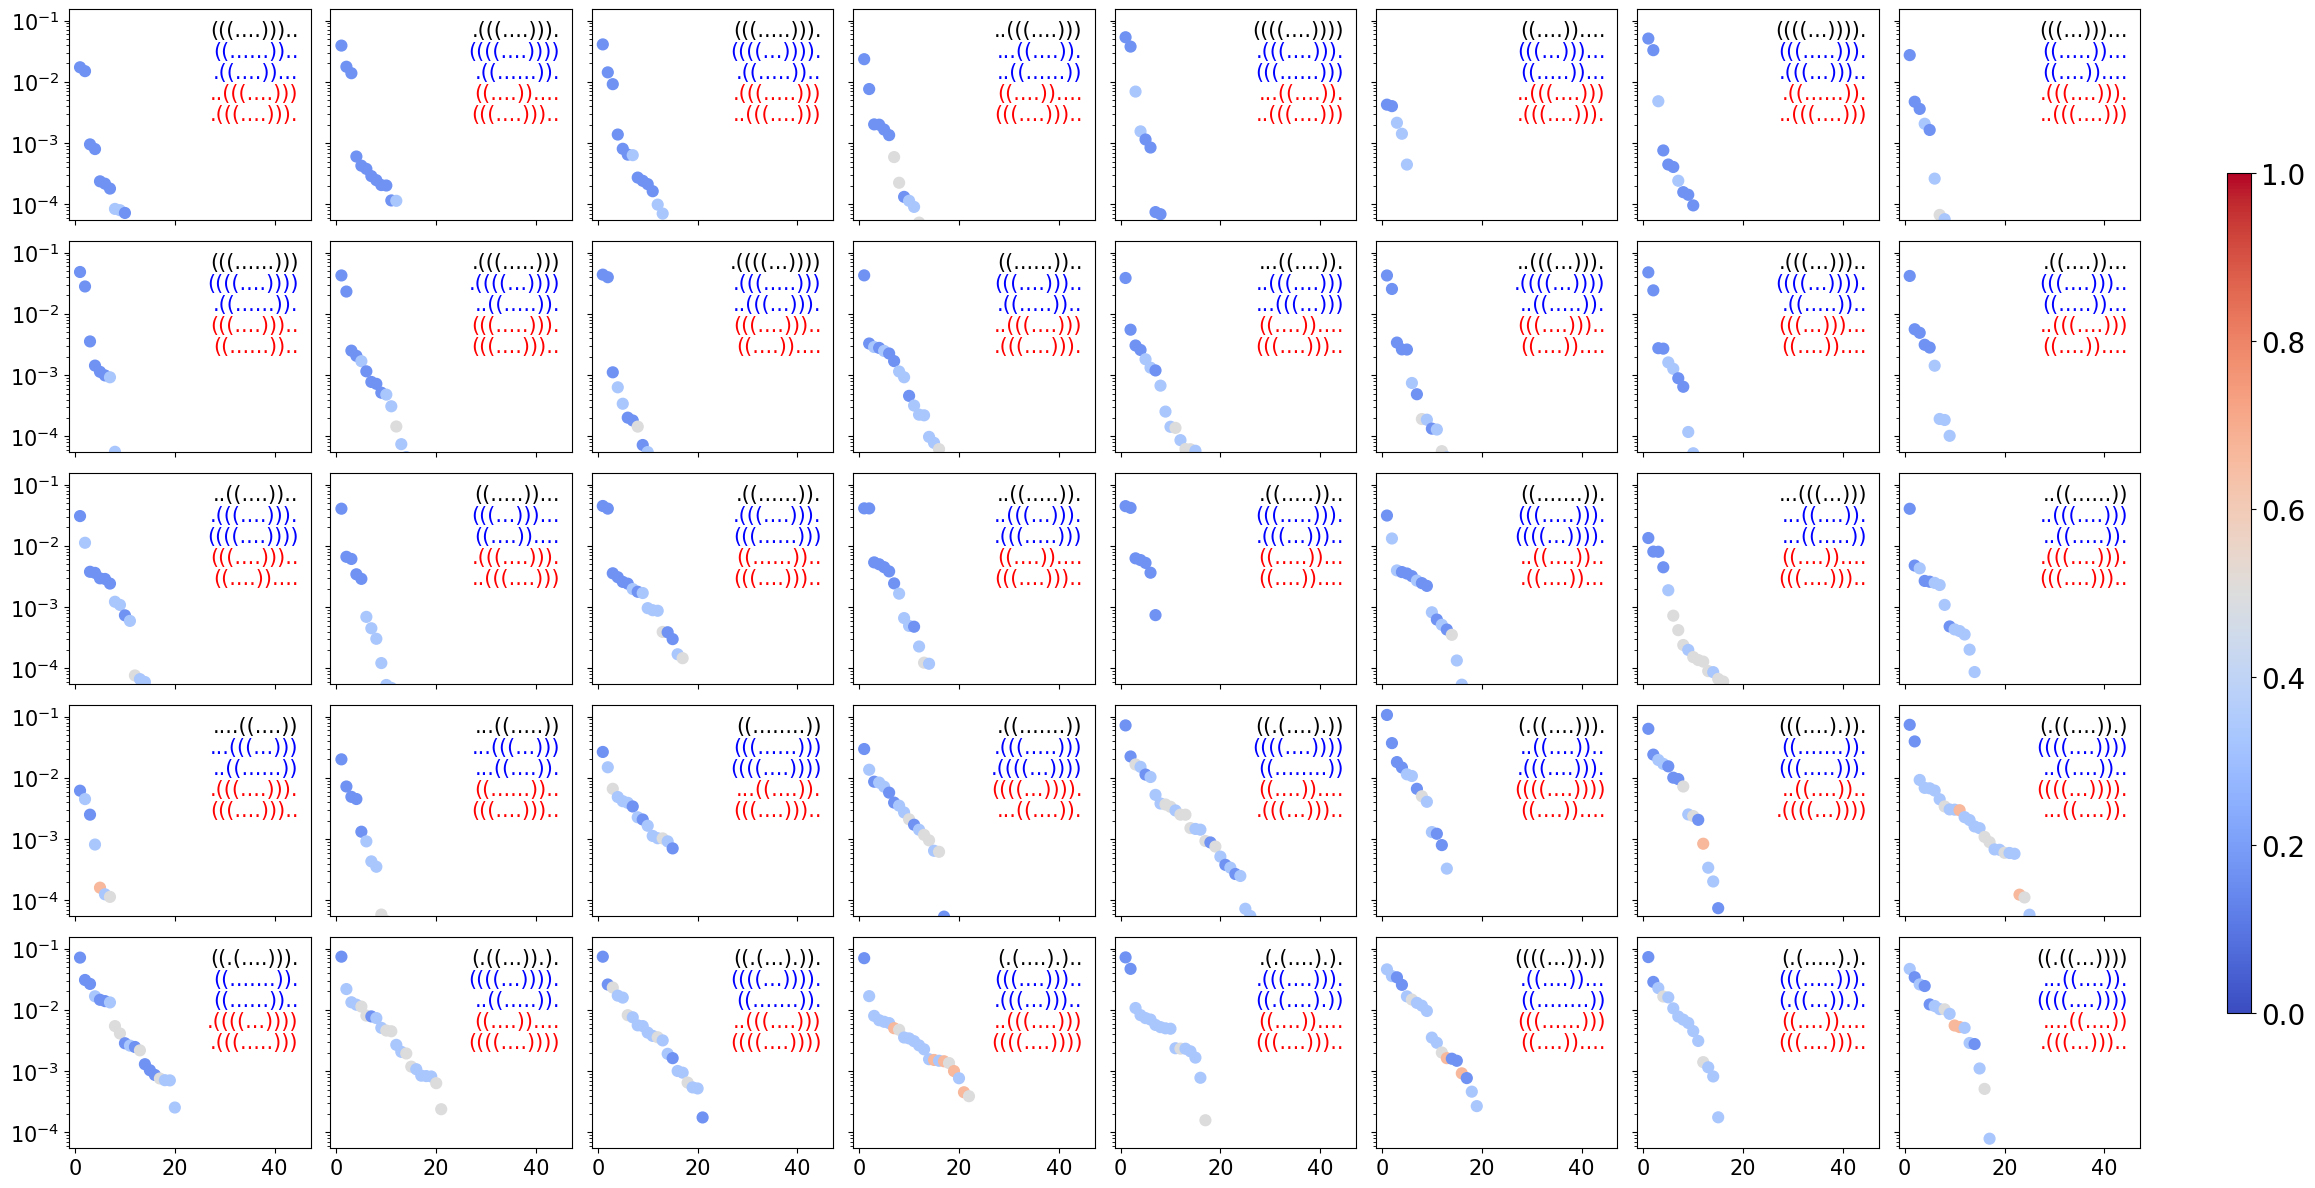

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import sys
from matplotlib.gridspec import GridSpec
sys.path.append('/home/pg520/phenodistance')
from main.functions.structurefunctions import hamming

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0.5, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Normalize the values
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        # Shift the values to the range [0, 1]
        result = np.ma.masked_array((result - vmin) / (vmax - vmin))
        result = np.ma.masked_array(np.interp(result, [0, midpoint, 1], [0, 0.5, 1]))

        if is_scalar:
            result = result[0]
        return result

# Create a grid layout with space for the colorbar
fig, axs = plt.subplots(5, 8, figsize=(24, 12), sharex=True, sharey=True)
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
cmap = plt.get_cmap('coolwarm')  # Get the colormap
norm = MidpointNormalize(vmin=0, vmax=1, midpoint=0.5)  # Use custom normalization

for i, ax in enumerate(axs.flatten()):
    if i < len(phipq):
        key = list(sort_neutralsets.keys())[i+1]
        qitems = phipq[key]
        listphipq = []
        listfreq = []
        distances = []
        listhamming = []
        phenos = []

        for q, phi in qitems.items():
            if q == '.'*L or q == key:  # Skip the neutral set and the del sequence
                continue
            listphipq.append(phi)
            listfreq.append(neutralsets[q+'\n'] / K**L)
            listhamming.append(hamming(key, q))
            # Calculate the distance from the point to the diagonal y = x
            distance = (phi - (neutralsets[q+'\n'] / K**L)) / np.sqrt(2)
            distances.append(distance)
            phenos.append(q)
        
        # Get the sorted indices of distances in descending order
        sorted_indices = np.argsort(distances)[::-1]
        
        # Sort distances and listhamming based on the sorted indices
        ranked_distances = np.array(distances)[sorted_indices]
        sorted_listhamming = np.array(listhamming)[sorted_indices]
        sorted_phenos = np.array(phenos)[sorted_indices]
        
        # Plot the distance versus its ranking
        scatter = ax.scatter(np.arange(1, len(ranked_distances)+1), ranked_distances, s=60, c=sorted_listhamming, cmap=cmap, norm=norm, alpha=1)
        ax.set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.text(0.95, 0.95, key, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=15)
        for j in range(1,3):
            ax.text(0.95, 0.95-0.1*j, f"{sorted_phenos[j-1]}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=15, color = 'blue')
        for k in range(1,3):
            ax.text(0.95, 0.95-0.1*j-0.1*k, f"{sorted_phenos[-2:][k-1]}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=15, color = 'red')
# Set common labels
#fig.text(0.5, 0.04, 'Ranking', ha='center', fontsize=20)
#fig.text(0.04, 0.5, 'Distance', va='center', rotation='vertical', fontsize=20)

# Add a colorbar for the entire figure on the side
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])  # Move to the right and make thinner
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
cbar.set_label('')
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the colorbar
plt.savefig("distance_ranking.png", bbox_inches='tight')
plt.show()

# Neutral correlations

In [2]:
with open("../data/rhopDPD.pkl","rb") as f:
    rhopDPD = pickle.load(f)
with open("../data/rhopMFE.pkl","rb") as f:
    rhopD= pickle.load(f)
with open("../data/neutralsetsDPD.pkl","rb") as f:
    neutralsetsDPD= pickle.load(f)

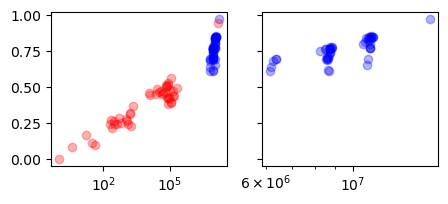

In [37]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(5,2), sharey=True)
ax[0].scatter(list(neutralsetsDPD.values()),list(rhopDPD.values()),color='blue',alpha=0.3)
ax[0].scatter(list(neutralsets.values()),list(rhopD.values()),color='red',alpha=0.3)
ax[0].set_xscale('log')

ax[1].scatter(list(neutralsetsDPD.values()),list(rhopDPD.values()),color='blue',alpha=0.3)
ax[1].set_xscale('log')

# Site quantities

Take the each site and calculate average Hamming distance (local and global) from each mutation on it in the neutral set.

In [5]:
import pickle
with open("../data/sitesevolvability.pkl","rb") as f:
    sitesevolvability = pickle.load(f)
with open("../data/sitesrobustness.pkl","rb") as f:
    sitesrobustness = pickle.load(f)
with open("../data/siteshammingmean.pkl","rb") as f:
    siteshammingmean = pickle.load(f)
with open("../data/siteshammingstd.pkl","rb") as f:
    siteshammingstd = pickle.load(f)

## Site robustness, evolvability and hamming distance

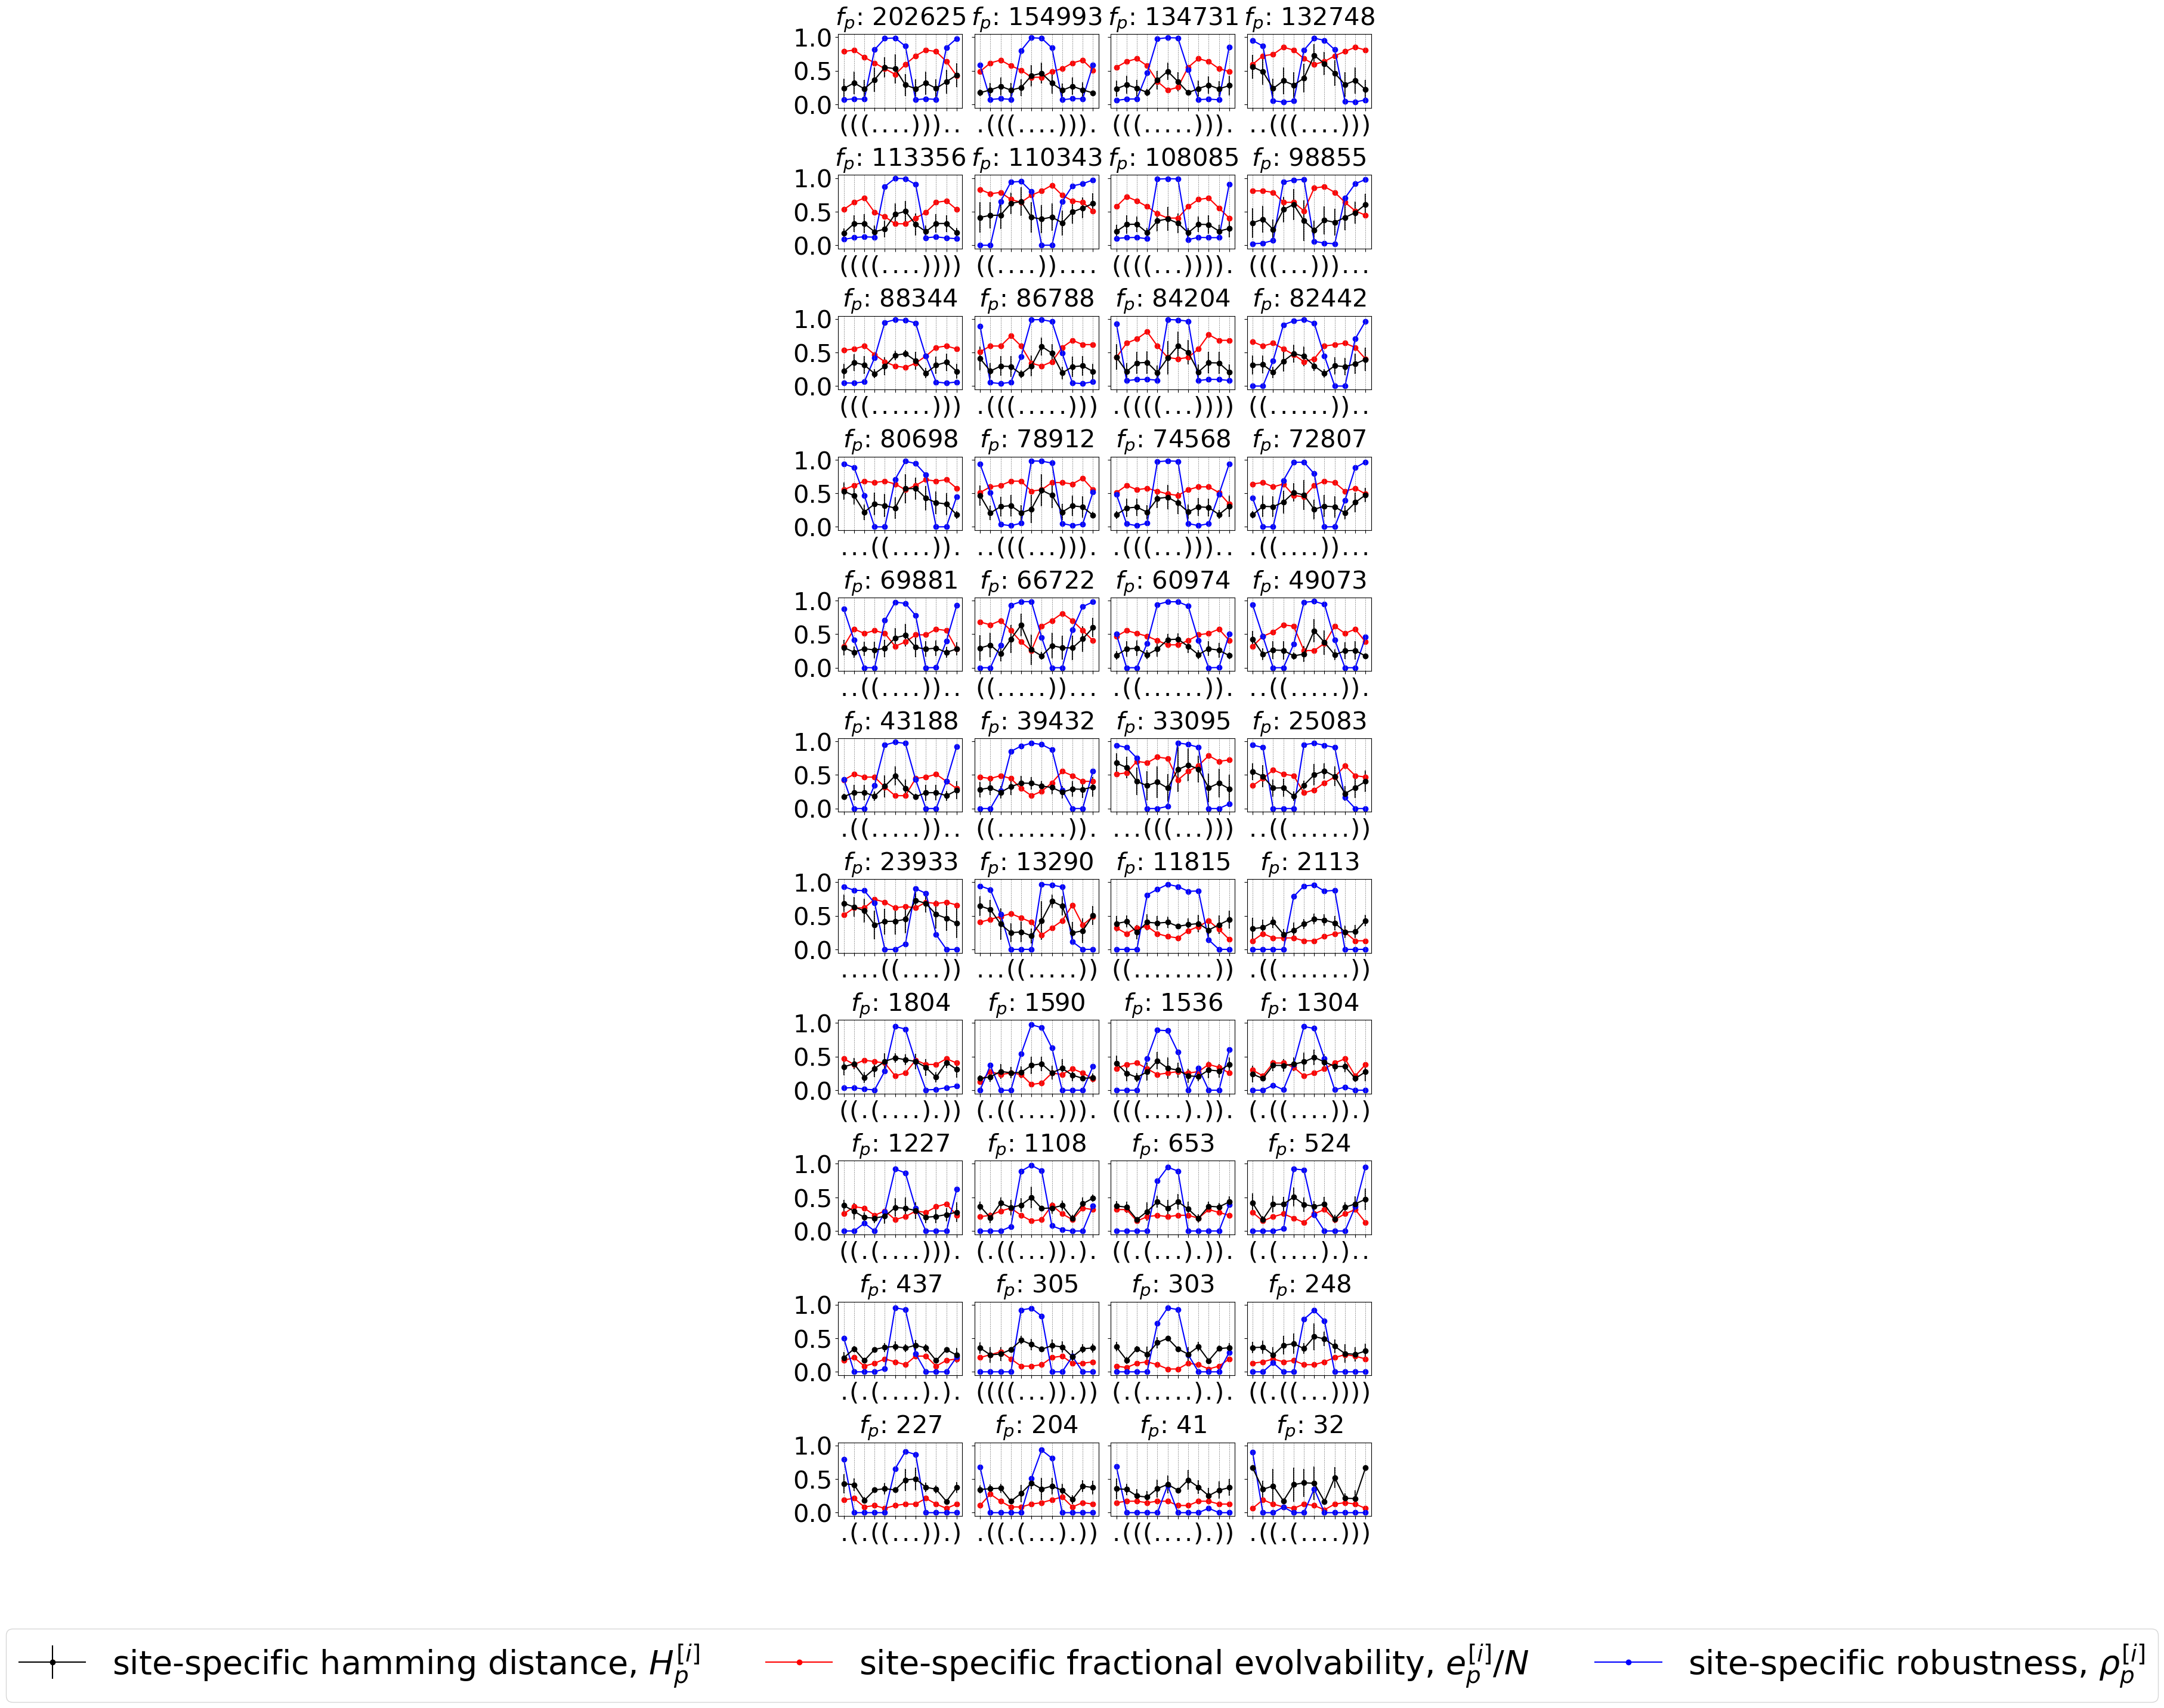

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import functools
import matplotlib.cm as cm


# Define the number of rows
num_rows = 11

# Calculate the number of columns needed
num_cols = 4

# Create a figure with the appropriate number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5), sharey=True)

# Flatten the axs array for easy iteration
axs = axs.flatten()
sites_pos = np.arange(1, L + 1, 1)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10

# Collect handles and labels for the legend
handles, labels = [], []
listneutralsets = list(sort_neutralsets.keys())

for i, ax in enumerate(axs):
    
    if i < len(listneutralsets):
        key = listneutralsets[i + 1]

        # Fill the data dictionary with relative areas
       

        # Plot the line plot on top of the bar plot
        siteshamming = [0] * L
        siteshammingerr = [0] * L
        dataevolvability = [0] * L
        dataevolvweight = [0] * L
        datarobust = [0] * L
        for site, avgs in siteshammingmean[key].items():
            siteshamming[site] = avgs
            siteshammingerr[site] = siteshammingstd[key][site]
            dataevolvability[site] = sitesevolvability[key][site]  # Fractional evolvability
            datarobust[site] = sitesrobustness[key][site]
        line1 = ax.errorbar(sites_pos, np.array(siteshamming), yerr=np.array(siteshammingerr), fmt = '-o', color='black', label=r'site-specific hamming distance, $H_p^{[i]}$')
        line2, = ax.plot(sites_pos, np.array(dataevolvability), '-o', color='red', label=r'site-specific fractional evolvability, $e_p^{[i]}/N$')
        line3, = ax.plot(sites_pos, np.array(datarobust), '-o', color='blue', label=r'site-specific robustness, $\rho_p^{[i]}$')

        # Collect handles and labels from the plots
        if i == 0:
            handles.extend([line1, line2, line3])
            labels.extend([line1.get_label(), line2.get_label(), line3.get_label()])

        # Custom x-tick labels with larger or bold characters
        new_labels = []
        sumchar = 0
        labeldict = Counter(key)
        for char in key:
            if char == '.' and sumchar == labeldict['(']:
                new_labels.append('.')
            else:
                if char == '(':
                    sumchar += 1
                elif char == ')':
                    sumchar -= 1
                new_labels.append(char)
        ax.set_xticks(sites_pos)
        ax.set_xticklabels(new_labels, size=20)
        ax.set_title(f'$f_p$: {sort_neutralsets[key]}', fontsize=30)
        ax.set_yticks([1.0, 0.5, 0.0])
        ax.tick_params(axis='both', which='major', labelsize=30)  # Set tick label size
        for pos in sites_pos:
            ax.axvline(x=pos, color='gray', linestyle='--', linewidth=0.5)

# Add a legend for the entire figure at the bottom with two rows
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=(len(listneutralsets) + 1) // 4, fontsize=40)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("evolvabilities.png", bbox_inches='tight')
plt.show()

## correlations


((.(...).)).
(.(....).)..
.(.(....).).
((((...)).))
(.(.....).).
((.((...))))
.(.((...)).)
.((.(...).))
.(((....).))
.((.(....)))
(((....)).).
..(.(....).)
(..(....)..)


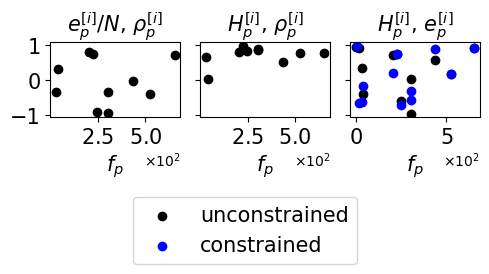

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict, OrderedDict
import functools
from matplotlib.ticker import ScalarFormatter

# Initialize variables
freq = []
corr_er_uc = []
corr_er_c = []
corr_er_in = []
corr_er = []
corr_hr_uc = []
corr_hr_c = []
corr_hr_in = []
corr_hr = []
corr_he_uc = []
corr_he_c = []
corr_he_in = []
corr_he = []
dataevolvabilitytott = []
datarobustnesstott = []
siteshamming = []
sitesminev = defaultdict(int)
datarobustpheno = defaultdict(float)


listneutralsets = list(sort_neutralsets.keys())
param= 2 #print range of neutral space size
params = {
    5: listneutralsets[1:8],
    4: listneutralsets[8:(8+20)],
    3: listneutralsets[(8+20):(8+20+7)],
    2: listneutralsets[(8+20+7):]
}
listneutralsets = params[param]
for key in listneutralsets:
    print(key)
    sitesum = 0
    dataevolvability_uc = []
    datarobustness_uc = []
    siteshamming_uc = []
    dataevolvability_c = []
    datarobustness_c = []
    siteshamming_c = []
    dataevolvability_in = []
    datarobustness_in = []
    siteshamming_in = []
    dataevolvability = []
    datarobustness = []
    siteshamming = []
    datarobustnesstot = []
    for site in range(12):
            dictsymbols = Counter(key)  # Count the number of symbols at each site
            #if sitesum >= dictsymbols['(']:
            #    siteshamming_in.append(avgs / edgeD_nodel[key][site])
            #    dataevolvability_in.append(phenos_site_evol[key][site] / (len(sort_neutralsets) - 1))  # Fractional evolvability
            #    datarobustness_in.append(phenos_site_robust[key][site] / edge_site_robust[key])  # Fractional robustness
            if key[site] == '.':
                siteshamming_uc.append(siteshammingmean[key][site])
                dataevolvability_uc.append(sitesevolvability[key][site])  # Fractional evolvability
                datarobustness_uc.append(sitesrobustness[key][site])
                sitesum += 0
            elif key[site] == '(':
                siteshamming_c.append(siteshammingmean[key][site])
                dataevolvability_c.append(sitesevolvability[key][site])
                datarobustness_c.append(sitesrobustness[key][site])
                sitesum += 1
            elif key[site] == ')':
                siteshamming_c.append(siteshammingmean[key][site])
                dataevolvability_c.append(sitesevolvability[key][site])
                datarobustness_c.append(sitesrobustness[key][site])
                sitesum -= 1
        
            siteshamming.append(siteshammingmean[key][site])
            dataevolvability.append(sitesevolvability[key][site])  # Fractional evolvability
            datarobustness.append(sitesrobustness[key][site])  # Fractional robustness
    
    corr_er_uc.append(np.corrcoef(datarobustness_uc, dataevolvability_uc)[0, 1])
    corr_er_c.append(np.corrcoef(datarobustness_c, dataevolvability_c)[0, 1])
    corr_er_in.append(np.corrcoef(datarobustness_in, dataevolvability_in)[0, 1])
    corr_er.append(np.corrcoef(datarobustness, dataevolvability)[0, 1])
    corr_hr_uc.append(np.corrcoef(siteshamming_uc, datarobustness_uc)[0, 1])
    corr_hr_c.append(np.corrcoef(siteshamming_c, datarobustness_c)[0, 1])
    corr_hr_in.append(np.corrcoef(siteshamming_in, datarobustness_in)[0, 1])
    corr_hr.append(np.corrcoef(siteshamming, datarobustness)[0, 1])
    corr_he_uc.append(np.corrcoef(siteshamming_uc, dataevolvability_uc)[0, 1])
    corr_he_c.append(np.corrcoef(siteshamming_c, dataevolvability_c)[0, 1])
    corr_he_in.append(np.corrcoef(siteshamming_in, dataevolvability_in)[0, 1])
    corr_he.append(np.corrcoef(siteshamming, dataevolvability)[0, 1])
    freq.append(sort_neutralsets[key])

#phenotype evolvability and robustness
#dataevolvabilitytott = []
#datarobustnesstott = []
#for pheno in evolvtot.keys():
#    dataevolvabilitytott.append(evolvtot[pheno])
#    datarobustnesstott.append(datarobustpheno[pheno])

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(5, 2), sharey=True)

# Collect handles and labels for the legend
handles, labels = [], []

# Plot the first subplot
scatter1 = axs[0].scatter(freq, corr_er_uc, color='black', label=r'unconstrained')
scatter2 = axs[0].scatter(freq, corr_er_c, color='blue', label=r'constrained')
#scatter3 = axs[0].scatter(freq, corr_er_in, color='green', label=r'(x) unconstrained only')
#scatter4 = axs[0].scatter(freq, corr_er, color='red', label=r'all sites')
#axs[0].set_xscale('log')
axs[0].set_xlabel('$f_p$', fontsize=15)
#axs[0].set_ylabel(r'Pearson $r$', fontsize=15)
axs[0].set_title(r'$e_p^{[i]}/N$, $\rho_p^{[i]}$', fontsize=15)
axs[0].tick_params(axis='both', which='major', labelsize=15)

# Plot the second subplot
axs[1].scatter(freq, corr_hr_uc, color='black', label=r'hr_uc')
axs[1].scatter(freq, corr_hr_c, color='blue', label=r'hr_c')
#axs[1].scatter(freq, corr_hr_in, color='green', label=r'hr_in')
#axs[1].scatter(freq, corr_hr, color='red', label=r'hr')
#axs[1].set_xscale('log')
#axs[1].set_ylabel(r'Pearson $r$', fontsize=15)
axs[1].set_xlabel('$f_p$', fontsize=15)
axs[1].set_title(r'$H_p^{[i]}$, $\rho_p^{[i]}$', fontsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=15)

# Plot the third subplot
axs[2].scatter(freq, corr_he_uc, color='black', label=r'he_uc', marker='o')
axs[2].scatter(freq, corr_he_c, color='blue', label=r'he_c')
#axs[2].scatter(freq, corr_he_in, color='green', label=r'he_in', marker='o')
#axs[2].scatter(freq, corr_he, color='red', label=r'he')
#axs[2].set_xscale('log')
axs[2].set_xlabel('$f_p$', fontsize=15)
axs[2].set_title(r'$H_p^{[i]}$, $e_p^{[i]}$', fontsize=15)
axs[2].tick_params(axis='both', which='major', labelsize=15)

# Collect handles and labels from the plots
#handles.extend([scatter1, scatter2, scatter3, scatter4])
#handles.extend([scatter1, scatter2, scatter4])
handles.extend([scatter1, scatter2])
#labels.extend([scatter1.get_label(), scatter2.get_label(), scatter3.get_label(), scatter4.get_label()])
labels.extend([scatter1.get_label(), scatter2.get_label()])

# Format x-ticks in scientific notation
for ax in axs:
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.xaxis.get_major_formatter().set_powerlimits((0, 0))
    ax.set_yticks([1.0, 0.0, -1.0])

# Add a legend for the entire figure at the bottom with two rows
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=1, fontsize=15)

# Show the plot
plt.tight_layout()
plt.savefig("correlations"+str(param)+".png", bbox_inches='tight')
plt.show()

# Prediction of largest jump?


In [7]:
from collections import Counter
from collections import defaultdict
import functools
phenosminev = defaultdict(functools.partial(defaultdict, list))
for pheno, phenos in phenos_site_nodel.items():
    for site, site_phenos in phenos.items():
        if site == sitesminev[pheno]:
            phenosminev[pheno][site] = list(dict(Counter(site_phenos)).keys())

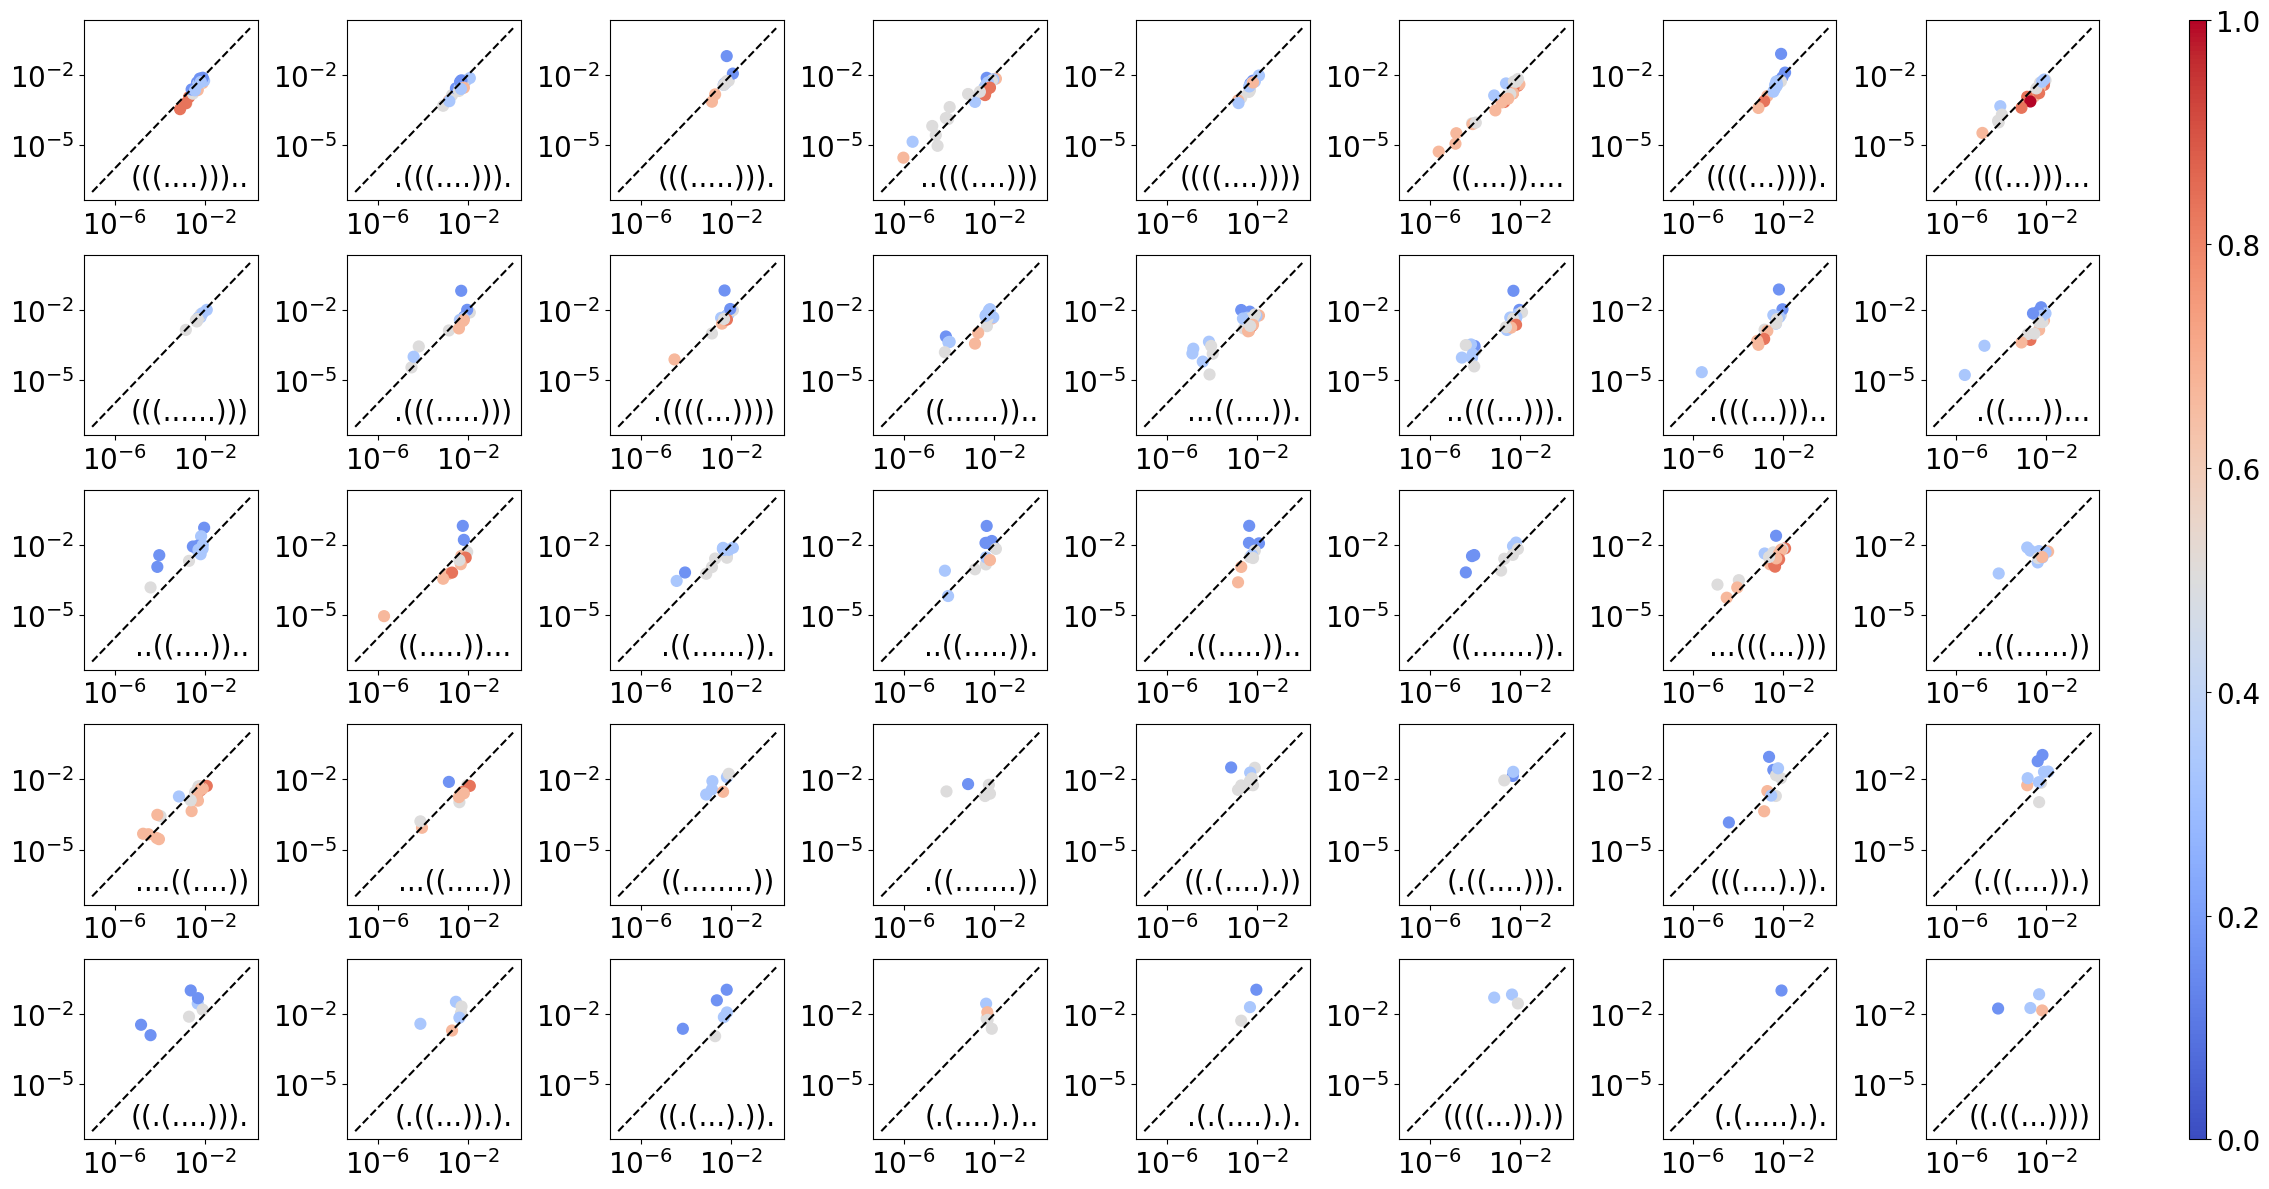

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import sys
from matplotlib.gridspec import GridSpec
sys.path.append('/home/pg520/phenodistance')
from main.functions.structurefunctions import hamming

class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0.5, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Normalize the values
        result, is_scalar = self.process_value(value)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        # Shift the values to the range [0, 1]
        result = np.ma.masked_array((result - vmin) / (vmax - vmin))
        result = np.ma.masked_array(np.interp(result, [0, midpoint, 1], [0, 0.5, 1]))

        if is_scalar:
            result = result[0]
        return result

# Create a grid layout with space for the colorbar
fig = plt.figure(figsize=(24, 12))
gs = GridSpec(5, 9, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.1])

plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.titlesize'] = 5
cmap = plt.get_cmap('coolwarm')  # Get the colormap
norm = MidpointNormalize(vmin=0, vmax=1, midpoint=0.5)  # Use custom normalization

axs = [fig.add_subplot(gs[i, j]) for i in range(5) for j in range(8)]

for i, ax in enumerate(axs):
    if i < len(phipq):
        key = list(sort_neutralsets.keys())[i+1]
        qitems = phipq[key]
        listphipq = []
        listhamming = []
        listfreq = []
        
        for q, phi in qitems.items():
            if q in phenosminev[key][sitesminev[key]]:  # Skip the neutral set and the del sequence
                listphipq.append(phi)
                listhamming.append(hamming(key, q))
                listfreq.append(neutralsets[q+'\n'] / K**L)
        
        scatter = ax.scatter(listfreq, listphipq, s=60, c=listhamming, cmap=cmap, norm=norm, alpha=1)  # Use the colormap to determine the color

        ax.plot([1e-7, 1], [1e-7, 1], color='black', linestyle='--')
        ax.set_xscale("log")
        ax.set_yscale('log')
        ax.set_xticks([1e-6, 1e-2])
        ax.text(0.95, 0.05, key, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)  # Set tick label size

# Add a colorbar for the entire figure on the side
cbar_ax = fig.add_subplot(gs[:, -1])  # Create an axis for the colorbar
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
cbar.set_label('')
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to make space for the colorbar
plt.savefig("phipq.png", bbox_inches='tight')
plt.show()